<a href="https://colab.research.google.com/github/Manvi0509/Manvi0509.github.io/blob/main/GRU_QR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# Load your AQI data
data = pd.read_excel(r"/content/DELHI_AQI.xlsx")
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

In [6]:
# Remove leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Define the columns for which you want to create lag features
columns = ['Max temp', 'Min temp', 'precip', 'windspeed', 'winddir',
           'PM2.5', 'PM10', 'NO2', 'SO2', 'Max 8-h CO', 'Max 8-h Ozone', 'AQI']


In [7]:
# Check which columns exist in the dataset
existing_columns = [col for col in columns if col in data.columns]

In [8]:
# Generate 1 lag for each available column (including original)
lags = 1
for col in existing_columns:
    # Create lagged feature
    data[f'{col}lag{lags}'] = data[col].shift(lags)
# Drop rows with NaN values (from lagged features)
data = data.dropna()

In [22]:
data

,AQI,Max temp,Min temp,precip,windspeed,winddir,PM2.5,PM10,NO2,SO2,...,preciplag1,windspeedlag1,winddirlag1,PM2.5lag1,PM10lag1,NO2lag1,SO2lag1,Max 8-h COlag1,Max 8-h Ozonelag1,AQIlag1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02,418,17.4,8.0,0.0,9.4,287.8,280.470588,439.810833,53.138824,11.885000,...,0.0,9.4,296.6,304.632353,440.251667,60.750588,17.066250,1.987692,34.130714,406.0
2018-01-03,382,17.2,8.0,0.0,11.2,270.8,219.991765,344.039167,53.151765,10.188750,...,0.0,9.4,287.8,280.470588,439.810833,53.138824,11.885000,1.708571,30.698571,418.0
2018-01-04,366,20.2,5.0,0.0,13.0,120.0,245.572941,395.775833,60.116471,14.302500,...,0.0,11.2,270.8,219.991765,344.039167,53.151765,10.188750,1.597143,31.054286,382.0
2018-01-05,390,19.0,7.4,0.0,11.2,112.3,241.658235,365.410000,55.786471,13.583750,...,0.0,13.0,120.0,245.572941,395.775833,60.116471,14.302500,1.477857,35.047143,366.0
2018-01-06,405,19.0,5.0,0.0,11.2,277.5,255.643529,390.452500,58.799375,17.837500,...,0.0,11.2,112.3,241.658235,365.410000,55.786471,13.583750,1.843846,28.534286,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,380,19.6,10.3,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,...,0.0,9.4,273.0,232.961983,358.345341,47.209648,8.970924,2.456401,32.644029,377.0
2023-12-28,358,19.5,9.3,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,...,0.0,9.4,255.4,263.062704,385.153366,43.086853,8.867617,2.313868,20.082292,380.0
2023-12-29,382,18.6,12.0,0.0,9.4,208.2,254.382753,406.617265,42.960487,9.634018,...,0.0,9.4,258.5,189.884393,295.297592,35.559144,9.113285,1.875346,21.922238,358.0


In [9]:
# Define predictors (both original and lagged features)
predictors = [f'{col}lag{lags}' for col in existing_columns]

In [10]:
# Define the training and testing data (80-20 split)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [11]:
X_train = train_data[predictors]
y_train = train_data['AQI']
X_test = test_data[predictors]
y_test = test_data['AQI']


In [12]:
# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Reshape for GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [14]:
# Define the custom Quantile Loss function
def quantile_loss(y_true, y_pred, quantile=0.85):
    error = y_true - y_pred
    loss = K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)
    return loss

In [15]:
# Define GRU model
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output one value per input sample
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compile the model with the Quantile Loss
model.compile(optimizer=Adam(learning_rate=0.01), loss=lambda y_true, y_pred: quantile_loss(y_true, y_pred, quantile=0.85))

In [17]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 148.3366 - val_loss: 25.3111
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.3793 - val_loss: 23.5226
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0487 - val_loss: 10.2602
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1286 - val_loss: 8.1104
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3501 - val_loss: 8.0840
Epoch 6/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6684 - val_loss: 8.0915
Epoch 7/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9212 - val_loss: 8.4453
Epoch 8/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6423 - val_loss: 8.6443
Epoch 9/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4526 - val_loss: 7.9025
Epoch 10/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2292 - val_loss: 7.9515
Epoch 11/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4302 - val_loss: 8.4373
Epoch 12/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3658 

In [18]:
# Predict on test data
predictions = model.predict(X_test).flatten()

# Compare actual vs predicted values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison.head(50))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
            Actual   Predicted
Timestamp                     
2022-10-20     229  310.580597
2022-10-21     282  305.719910
2022-10-22     271  328.181000
2022-10-23     237  306.192749
2022-10-24     333  304.221771
2022-10-25     303  319.225159
2022-10-26     282  314.289490
2022-10-27     350  329.807495
2022-10-28     355  377.265656
2022-10-29     403  395.966980
2022-10-30     348  412.954773
2022-10-31     379  395.141785
2022-11-01     419  430.412537
2022-11-02     384  421.767517
2022-11-03     459  409.211823
2022-11-04     434  462.317505
2022-11-05     369  444.212463
2022-11-06     333  363.935608
2022-11-07     332  351.887238
2022-11-08     356  368.061218
2022-11-09     264  399.794952
2022-11-10     281  307.570923
2022-11-11     304  340.741943
2022-11-12     291  360.299530
2022-11-13     277  338.770874
2022-11-14     246  337.397583
2022-11-15     165  321.941162
2022-11-16     233  275.502502
2022-11-17     198  274.120483

In [19]:
# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


In [20]:
# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error (MAE): 40.464637756347656
Mean Squared Error (MSE): 2796.303955078125
R-squared: 0.7614544034004211


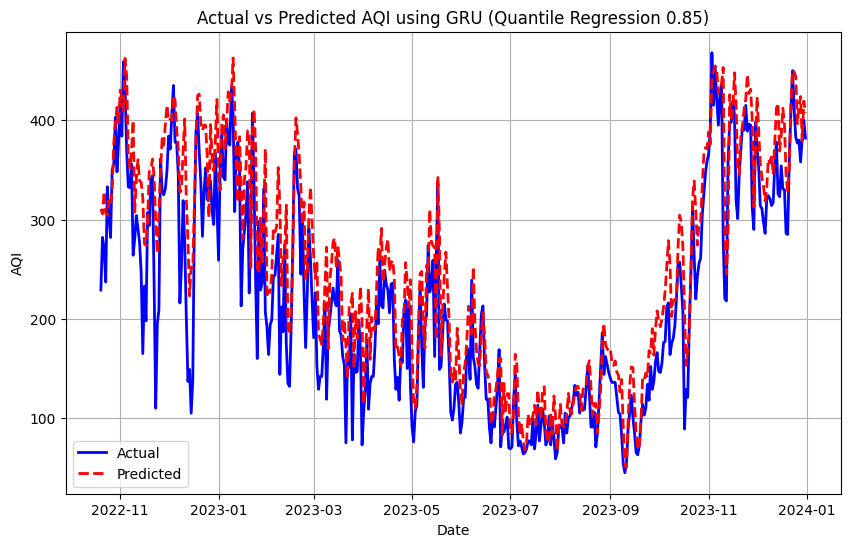

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI using GRU (Quantile Regression 0.85)')
plt.legend()
plt.grid(True)
plt.show()